QLBM algorithm solving diffusion equation using D1Q2 scheme and IPE algorithm (Section IV-C)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math, time, pickle
import qiskit
from qiskit import IBMQ, Aer, transpile, assemble,execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT
from qiskit.circuit.gate import Gate
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.circuit.library import Permutation
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.result import marginal_counts
from qiskit.visualization import plot_histogram
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

plt.rc('axes', labelsize=9.)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9.)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9.)    # fontsize of the tick labels
plt.rc('legend', fontsize=9.)    # fontsize of the tick labels
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

Constants definition 

In [3]:
# D1Q2 lattice constants
D = 0.5    #diffusion constant
w = np.array([0.5, 0.5]) # weight coefficients
cx = np.array([1, -1])   #lattice velocities
csq = 1   #square of sound speed
ux = 0.  # advection x-velocity

Functions

In [4]:
def compute_feq(rho, w, cx, ux, csq):
    feq = np.zeros((2,M))
    for i in range(2):
        feq[i] = w[i] * (1 + cx[i]*ux/csq) * rho
    return feq

def ini(x, w, cx, ux, csq):
    M = len(x)
    rho = np.ones(M)    #initial density
    rho = 1/4 * np.exp(-(x-mu0)**2 / sigma0**2) + 1/2
    feq = compute_feq(rho, w, cx, ux, csq)
    f = feq
    return f, rho

def update_encoding(qc, f, M):
    for k in range(M):
        for i in range(2):    
            amp0 = np.sqrt(1-f[i][k])
            amp1 = np.sqrt(f[i][k])
            qc.initialize([amp0, amp1], i+2*k)  
    return qc

def update_encoding_combined(qc, f, k):
    amp00 = np.sqrt( (1-f[0][k]) * (1-f[1][k]) ) 
    amp10 = np.sqrt( (1-f[0][k]) * f[1][k] )
    amp01 = np.sqrt( (1-f[1][k]) * f[0][k] )
    amp11 = np.sqrt( f[0][k] * f[1][k] )
    vector = np.array([amp00, amp01, amp10, amp11])
    qc.prepare_state(vector, [0,1])
    return qc

def collision_Diffusion(circ, k):
    circ.cx(0+2*k, 1+2*k)
    circ.csx(1+2*k, 0+2*k)
    circ.cx(0+2*k, 1+2*k)
    circ.draw()
    return circ

def computeStreamingPattern(n):
    if (n >= 4):  #minimum for streaming is 2 sites, corresonding to 4qubits
        #first pair of qubits
        streamingPattern = [n-2, 3]
        for i in range(2,n-3):
            if i%2 == 0:  
                streamingPattern.extend([i-2, i+3])
        #last pair of qubits
        streamingPattern.extend([n-4,1])
    else:
        streamingPattern = []
    return streamingPattern

def isConjugate(x,y):
    return (abs(x.real - y.real) < 1e-9) and (abs(x.imag + y.imag) < 1e-9)

def isEqual(x,y):
    return (abs(x.real - y.real) < 1e-9) and (abs(x.imag - y.imag) < 1e-9)

# identify the correct four eigenvalues with minimal number of iterations
def identify_eigenvalues(eigenvalues):
    result = np.zeros(4).astype(complex)
    bothPos = False
    bothNeg = False
    for i in range(len(eigenvalues)):
        for j in range(1, len(eigenvalues)-i):
            if isConjugate(eigenvalues[i], eigenvalues[i+j]):
                if eigenvalues[i].imag > 0:
                    idx1 = i+j
                    idx2 = i
                else:
                    idx1 = i
                    idx2 = i+j     
                break
            elif isEqual(eigenvalues[i], eigenvalues[i+j]):
                if eigenvalues[i].imag > 0:
                    bothPos = True
                    idx1 = i+j
                    idx2 = i
                else:
                    bothNeg = True
                    idx1 = i
                    idx2 = i+j     
                break
    
    result[0] = eigenvalues[idx1]
    result[1] = eigenvalues[idx2]
    
    if bothPos:
        result[0] = np.conj(result[0])
    if bothNeg:
        result[1] = np.conj(result[1])
        
    idx4Defined = False
    idx3Defined = False
    for i in [x for i,x in enumerate(range(len(eigenvalues))) if i!=idx1 and i!=idx2]:  
        if eigenvalues[i].imag >= 0 and not idx4Defined:
            idx4 = i 
            idx4Defined = True
            continue
        if eigenvalues[i].imag != 0 and not idx3Defined:
            idx3 = i
            idx3Defined = True
    
    if idx3Defined:
        if not idx4Defined:
            for i,x in enumerate(range(len(eigenvalues))):
                if i!=idx1 and i!=idx2 and i!=idx3:       
                    idx4 = i
            eigenvalues[idx4] = eigenvalues[idx3].imag + eigenvalues[idx3].real*1j
        if(eigenvalues[idx4].imag >= 1e-9): #diff than 0
            eigenvalues[idx4] = eigenvalues[idx3].imag + eigenvalues[idx3].real*1j
        if eigenvalues[idx4].imag < 1e-9:
            result[2] = 0
            result[3] = 0
        elif abs(eigenvalues[idx4].imag - eigenvalues[idx3].real) < 1e-9 and abs(eigenvalues[idx4].real - eigenvalues[idx3].imag) < 1e-9:
            result[2] = eigenvalues[idx3]
            result[3] = eigenvalues[idx4]
        else:
            result[2] = 0
            result[3] = 0
    else:
        result[2] = 0
        result[3] = 0
        
    return result
 
# calculate phases from eigenvalues 'lambdas'
def computePhase(lambdas, f1, f2):
    if abs(lambdas[2] + lambdas[3]) < 1e-9:
        return 0, False
    else:
        denom = (lambdas[1] - lambdas[0]) / (2*1j)
        num = (lambdas[2] + lambdas[3]) / (1+1j)
        temp = (lambdas[2] - lambdas[3]) / (1j*(lambdas[2] + lambdas[3]))
        num *= np.sqrt(temp*temp-1)
        num /= np.sqrt(2)
        if f1<f2:
            return math.atan2(-np.abs(num), np.abs(denom)), True
        else:
            return math.atan2(np.abs(num), np.abs(denom)), True


# calculate probabilities from eigenvalues 'lambdas' to be used in IPE of next time step
def computeF(lambdas):
    A = (lambdas[0] + lambdas[1]) / 4 + (lambdas[2] + lambdas[3]) / (2*(1+1j))
    temp = -(lambdas[1] - lambdas[0])**2/8 - (lambdas[2]**2 + lambdas[3]**2) / (4*1j)
    return 1 - A**2 - temp/2

# permute probabilities to be used in IPE of next time step
def permute(f): 
    temp = f[0][M-1]
    f[0][1:M] = f[0][0:M-1]
    f[0][0] = temp
    temp = f[1][0]
    f[1][0:M-1] = f[1][1:M]
    f[1][M-1] = temp
    return f

# measure 'qubit' in the X-basis, and store the result in 'cbit'
def x_measurement(qc, qubit, cbit):
    qc.h(qubit)
    qc.measure(qubit, cbit)
    
# return list of indices for which the bit is '1' in binary equivalent of number 'x'
def block(x):
    result = []
    v = []
    # convert the decimal number into its binary equivalent
    while (x > 0):
        v.append(int(x % 2))
        x = int(x / 2)
    # return index when bit is 1
    for i in range(0, len(v)):
        if (v[i] == 1):  
            result.append(i)
    return result

One time step of measurement-avoiding QLBM with quantum streaming and IPE (Section IV-C)

In [5]:
def OneTimeStep(qcMain, f, M, backend, t, maxT, numberOfShots, num_iterations):
    # step 1 : collision
    for k in range(M):
        qcMain = collision_Diffusion(qcMain, k)
    qcMain.draw()
    
    # step2: streaming
    qcMain.append(Permutation(num_qubits = n, pattern = computeStreamingPattern(n)), range(2*M))
    qcMain.draw() 
    
    # step 3: estimate and remove phase resulting from previous time step using IPE circuit
    if t>1:
        eigenvalues = np.zeros((M,4)).tolist()
        eigenvaluesOrdered = np.zeros((M,4)).astype(complex)
        phase = np.zeros(M)
        phase2 = np.zeros((2,M))
        for l in range(M):  #apply QPE to each pair
            qr = QuantumRegister(3)   # 1 ancilla + 2 qubits
            cr = ClassicalRegister(num_iterations) #We measure num_iterations phase bits
            qc = QuantumCircuit(qr,cr)

            #prepare controlled U (oracle)
            qcU = QuantumCircuit(2)
            qcU = update_encoding_combined(qcU, f, l)
            qcU = collision_Diffusion(qcU,0)
            c_U = qcU.control(1, label='Controlled-U') #Form controlled operations of the gate which gives a phase
            
            #1st step
            qc.h(0)    #initialize
            for _ in range(2**(num_iterations-1)):  #apply control U operations
                qc.append(c_U,[0,1,2])
            x_measurement(qc, 0, cr[0])  #measure ancilla in x-basis
            
            #following steps (k-th step)
            for k in range(2,num_iterations+1):
                qc.reset(0)
                qc.h(0)    #initialize
                #phase correction 2**(k-1)-1 possible cases #only if cr = 01 (phi_m=1)
                for j in range(1, 2**(k-1)):
                    indices = [ 1/2**(k-x) for x in block(j) ]
                    rotAngle = sum(indices)  
                    qc.p(-2*np.pi*rotAngle,0).c_if(cr,j)   #phase correction only if cr = 01 (phi_m=1)
                for _ in range(2**(num_iterations-k)):  #apply control U operations
                    qc.append(c_U,[0,1,2])
                x_measurement(qc, 0, cr[k-1])  #measure ancilla in x-basis

            res = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
            answer = res.get_counts()
            answer = dict(sorted(answer.items(), key=lambda item: item[1], reverse=True))
            #get 4 most probable eigenvalues
            count = 0
            for key, value in answer.items():
                if count <= 3:
                    phi = int(key,2)/(2**(num_iterations))
                    eigenvalue = math.cos(2*math.pi*phi) + 1j* math.sin(2*math.pi*phi)
                    eigenvalues[l][count]= eigenvalue
                    count += 1
        #calculate phase and subtract it for each pair 
        for k in range(M):  
            eigenvaluesOrdered[k] = identify_eigenvalues(eigenvalues[k])     
            phase[k], fNot0 = computePhase(eigenvaluesOrdered[k], f[0][k], f[1][k])
            phase2[0][k] = phase[k]
            phase2[1][k] = phase[k]
            if fNot0:
                f[0][k] = computeF(eigenvaluesOrdered[k])
                f[1][k] = computeF(eigenvaluesOrdered[k])
        phase2 = permute(phase2)
        for k in range(M):  
            qcMain.p(-phase2[0][k], 0+2*k)
            qcMain.p(phase2[1][k], 1+2*k)
    f = permute(f)

    #  measurement only at end
    if t == maxT:
        qcMain.measure_all()
        result = execute(qcMain, backend, shots=numberOfShots).result()
        counts = result.get_counts(0)
        qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(2*M)]

        #read post streaming probabilities
        fout = np.zeros((2,M))
        for k in range(M):
            for i in range(2):
                if '1' in qubit_counts[i+2*k]:
                    fout[i][k] = qubit_counts[i+2*k]['1'] / numberOfShots
        f = fout
            
    return f, qcMain

Classical implementation of QLBM algorithm

In [6]:
# number operators
n1 = np.array([[0, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 1]])
n2 = np.array([[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
 
# collision operator 
C_Diffusion = np.array([[1, 0, 0, 0],
                      [0, (1+complex(0,1))/2 , (1-complex(0,1))/2 , 0],
                      [0, (1-complex(0,1))/2 , (1+complex(0,1))/2 , 0],
                      [0, 0, 0, 1]])


def classicalOneTimeStep(f, M):
#     initial combined state
    initial_state = np.zeros((M, 4))
    for i in range(M):
        amp00 = np.sqrt( (1-f[0][i]) * (1-f[1][i]) )#2nd index = lattice site
        amp10 = np.sqrt( (1-f[0][i]) * f[1][i] )
        amp01 = np.sqrt( (1-f[1][i]) * f[0][i] )
        amp11 = np.sqrt( f[0][i] * f[1][i] )
        initial_state[i][0] = amp00
        initial_state[i][1] = amp01
        initial_state[i][2] = amp10
        initial_state[i][3] = amp11
    

#     post-collision state (4xlattice_sites)
    post_collision_state = C_Diffusion.dot(initial_state.conjugate().transpose())
    
   # post-collision distribution
    post_collision_distribution = np.zeros((2, M))
    for i in range(M):
        post_collision_distribution[0][i] = post_collision_state.conjugate().transpose()[i].dot(n1.dot( post_collision_state.transpose()[i]))
        post_collision_distribution[1][i] = post_collision_state.conjugate().transpose()[i].dot(n2.dot( post_collision_state.transpose()[i]))

#     STREAMING STEP 
    f[0][1:M] = post_collision_distribution[0][0:M-1]
    f[1][0:M-1] = post_collision_distribution[1][1:M]

#      periodic BC as imposed by permutation function
    f[0][0] = post_collision_distribution[0][M-1]
    f[1][M-1] = post_collision_distribution[1][0]

    return f

Simulation parameters 

In [16]:
L = 4  # domain length 
M = L+1  # number of lattice sites (from 0 to L)
n = 2*M   # number of qubits
x = np.array(range(M)) # 1D lattice

#initial condition: gaussian distribution
sigma0 = L/10  # mean
mu0 = int(np.ceil(L/2)) # variance

numberOfShots = 100000  # number of shots
maxT = 3   # number of time steps

backend = 'aer_simulator_matrix_product_state' # simulation backend

num_iterations = 12 #number of iterations for IPE algorithm


Main loop 

In [17]:
#initialize circuit
circ = QuantumCircuit(n)
# prepare initial state only at the beginning
f, rho = ini(x, w, cx, ux, csq)
fq = f.copy()
circ = update_encoding(circ, fq, M)
fClassical = f.copy()


for t in range(1, maxT+1):
    print('t = ', t)
    if t==3:
        num_iterations = 14
    if t>=4:
        num_iterations = 15
            
    #quantum simulation
    fq, circ = OneTimeStep(circ, fq, M, Aer.get_backend(backend), t, maxT, numberOfShots, num_iterations)
    rho_q = fq[0] + fq[1]
    #classical implementation
    fClassical = classicalOneTimeStep(fClassical, M)
    rhoClassical = fClassical[0] + fClassical[1]
print('Done')

t =  1
t =  2


/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


t =  3
Done


Results output and plot

RMSE of measurement-avoiding quantum solution:
 0.002131332966101854


Text(0, 0.5, 'Density')

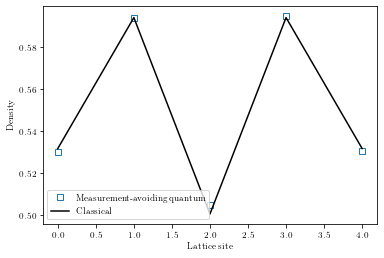

In [18]:
MSE = mean_squared_error(rhoClassical, rho_q)
RMSE = math.sqrt(MSE)
print("RMSE of measurement-avoiding quantum solution:\n", RMSE)

plt.plot(x, rho_q,'s', markersize = 6, markerfacecolor='none')
plt.plot(x, rhoClassical, 'k')
plt.legend(['Measurement-avoiding quantum ', 'Classical']) 
plt.xlabel('Lattice site')
plt.ylabel('Density')